In [1]:
!nvidia-smi

Mon Mar 22 18:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
class_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

In [5]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (60000, 28, 28, 1)
Shape of y_train:  (60000, 10)
Shape of x_test:  (10000, 28, 28, 1)
Shape of y_test:  (10000, 10)


In [6]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 28

In [7]:
# Put aside a few samples to create our validation set
val_samples = 1000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [8]:
@tf.function
def get_bbox(l):
  cut_rat = tf.math.sqrt(1.-l)

  cut_w = IMAGE_SIZE*cut_rat #rw
  cut_w = tf.cast(cut_w, tf.int32)
  
  cut_h = IMAGE_SIZE*cut_rat #rh
  cut_h = tf.cast(cut_h, tf.int32)
  
  cx = tf.random.uniform((1,), minval=0, maxval=IMAGE_SIZE, dtype=tf.int32) #rx
  cy = tf.random.uniform((1,), minval=0, maxval=IMAGE_SIZE, dtype=tf.int32) #ry
  
  bbx1 = tf.clip_by_value(cx[0] - cut_w // 2, 0, IMAGE_SIZE)
  bby1 = tf.clip_by_value(cy[0] - cut_h // 2, 0, IMAGE_SIZE)
  bbx2 = tf.clip_by_value(cx[0] + cut_w // 2, 0, IMAGE_SIZE)
  bby2 = tf.clip_by_value(cy[0] + cut_h // 2, 0, IMAGE_SIZE)
  
  target_h = bby2-bby1
  if target_h ==0:
    target_h+=1

  target_w = bbx2-bbx1
  if target_w ==0:
    target_w+=1

  return bbx1, bby1, target_h, target_w

@tf.function
def cutmix(a, b):
  
  (image1, label1), (image2, label2) = a, b

  alpha = [1.]
  beta = [1.]
  
  ## Get sample from beta distribution
  dist = tfd.Beta(alpha, beta)
  ## Lambda
  l = dist.sample(1)[0][0]

  ## Get bbox ofsets and heights anda widths
  bbx1, bby1, target_h, target_w = get_bbox(l)

  ## Get patch from image2
  crop2 = tf.image.crop_to_bounding_box(image2, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  image2 = tf.image.pad_to_bounding_box(crop2, bby1, bbx1, IMAGE_SIZE, IMAGE_SIZE)
  ## Get patch from image1
  crop1 = tf.image.crop_to_bounding_box(image1, bby1, bbx1, target_h, target_w)
  ## Pad the patch with same offset
  img1 = tf.image.pad_to_bounding_box(crop1, bby1, bbx1, IMAGE_SIZE, IMAGE_SIZE)

  ## Subtract the patch from image1 so that patch from image2 can be put on instead
  image1 = image1-img1
  ## Add modified image1 and image2 to get cutmix image
  image = image1+image2

  ## Adjust lambda according to pixel ration
  l = 1 - (target_w * target_h) / (IMAGE_SIZE * IMAGE_SIZE)
  l = tf.cast(l, tf.float32)

  ## Combine labels
  label = l*label1+(1-l)*label2

  return image, label

In [9]:
train_ds_cmu = (
    train_ds
    .map(cutmix, num_parallel_calls=AUTO)
)

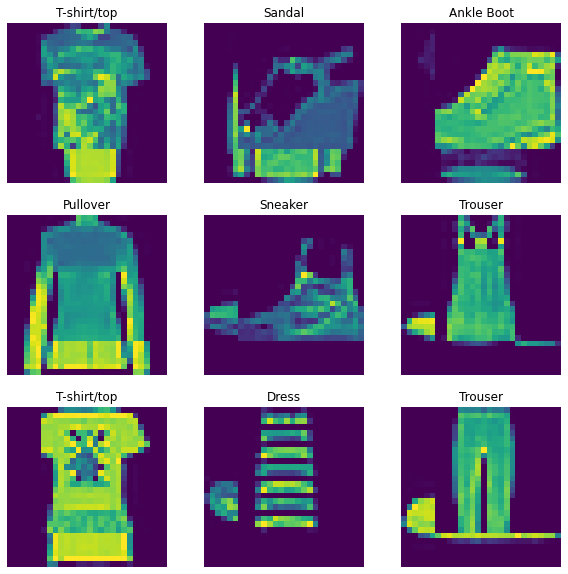

In [10]:
sample_images, sample_labels = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_name[np.argmax(label.numpy().tolist())])
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

In [11]:
def training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [12]:
initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [13]:
print(len(train_ds_cmu))

1844


In [14]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=val_ds, epochs=EPOCHS)
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/10
1844/1844 [==============================] - 10s 4ms/step - loss: 1.7305 - accuracy: 0.4513 - val_loss: 0.8069 - val_accuracy: 0.7500
Epoch 2/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.4241 - accuracy: 0.6025 - val_loss: 0.6139 - val_accuracy: 0.7930
Epoch 3/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.3202 - accuracy: 0.6451 - val_loss: 0.5789 - val_accuracy: 0.8280
Epoch 4/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.3079 - accuracy: 0.6516 - val_loss: 0.5357 - val_accuracy: 0.8280
Epoch 5/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.2560 - accuracy: 0.6628 - val_loss: 0.5067 - val_accuracy: 0.8530
Epoch 6/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.2245 - accuracy: 0.6773 - val_loss: 0.4788 - val_accuracy: 0.8660
Epoch 7/10
1844/1844 [==============================] - 7s 4ms/step - loss: 1.2073 - accuracy: 0.6877 - val_loss: 0.4742 - val_accuracy

In [15]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)

test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
1844/1844 [==============================] - 6s 3ms/step - loss: 1.0750 - accuracy: 0.6015 - val_loss: 0.6189 - val_accuracy: 0.7640
Epoch 2/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.6216 - accuracy: 0.7674 - val_loss: 0.4917 - val_accuracy: 0.8210
Epoch 3/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.5264 - accuracy: 0.8099 - val_loss: 0.3926 - val_accuracy: 0.8700
Epoch 4/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.4496 - accuracy: 0.8368 - val_loss: 0.3559 - val_accuracy: 0.8710
Epoch 5/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.4157 - accuracy: 0.8477 - val_loss: 0.3488 - val_accuracy: 0.8780
Epoch 6/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.3901 - accuracy: 0.8562 - val_loss: 0.3216 - val_accuracy: 0.8810
Epoch 7/10
1844/1844 [==============================] - 6s 3ms/step - loss: 0.3689 - accuracy: 0.8638 - val_loss: 0.3168 - val_accuracy: